In [3]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

import matplotlib.pyplot as plt

import random

/home/yuandong/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
d = 41

In [25]:
import random

complex_type = torch.cdouble
real_type = torch.double

v = torch.ones(d, dtype=complex_type)
# unit 
for i in range(d):
    v[i].real = math.cos(2 * math.pi * i / d)
    v[i].imag = math.sin(2 * math.pi * i / d)
    
U = torch.zeros(d, d, dtype=complex_type, requires_grad=False)
for i in range(d):
    U[:,i] = v ** i / math.sqrt(d)
    
U = U.conj()

In [26]:
# multiplication table
mul_table = torch.zeros(d, d, dtype=torch.int)

for i in range(d):
    for j in range(d):
        mul_table[i, j] = (i + j) % d
        
# distribution of each entry
probs = torch.ones(d, d)

# multiplication table
mul_table = torch.zeros(d, d, dtype=torch.int)

for i in range(d):
    for j in range(d):
        mul_table[i, j] = (i + j) % d
        
n = d * d

X = torch.zeros(n, 2 * d)
Y = torch.zeros(n, d)
targets = torch.zeros(n, dtype=torch.int)

for i in range(n):
    j, k = i // d, i % d
    X[i, j] = 1
    X[i, k + d] = 1
    Y[i, mul_table[j, k]] = 1
    targets[i] = mul_table[j, k]
    
# Normalized one hot.
# X = X - 2 / d
# Y = Y - 1 / d

# sort according to y.
sorted_targets, y_indices = targets.sort()

# Specify the distribution of data
probs = (torch.rand(n) > 0.2).float()

print((probs == 1).sum())
# probs = torch.rand(n)
# probs = torch.ones(n)

# Then 

tensor(1350)


In [27]:
# compute the backpropagated gradient

def compute_dF(F, probs, Y, eps):
    est_W = (F.t() @ probs.diag() @ F + eps * torch.eye(F.size(1)).to(F.device)).inverse() @ (F.t() @ probs.diag() @ Y)

    hatY = F @ est_W
    dF = probs.diag() @ (Y - hatY) @ est_W.t()
    
    return dF

In [28]:
def compute_dF2(F, probs, Y, eps):
    # Compute the eigenvector of F.t() @ probs.diag() @ F. 
    est_W = F.t() @ probs.diag() @ Y

    hatY = F @ est_W
    dF = probs.diag() @ (Y - hatY) @ est_W.t()
    
    return dF

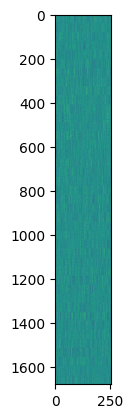

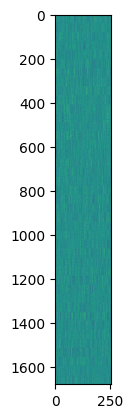

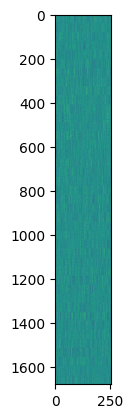

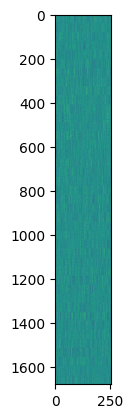

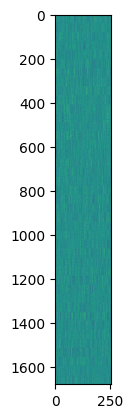

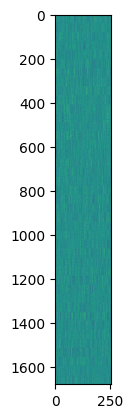

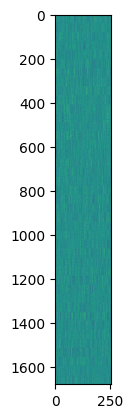

In [29]:
# compute_dF and check its structure
K = 1024
F = torch.randn(n, K)
# F = F ** 2

# F = F - F.mean(dim=1, keepdim=True)

for eps in [1e-3, 1e-2, 1e-1, 2e-1, 3e-1, 5e-1, 1]:
    dF = compute_dF2(F, probs, Y, eps)
    plt.imshow(dF[y_indices,:256])
    plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

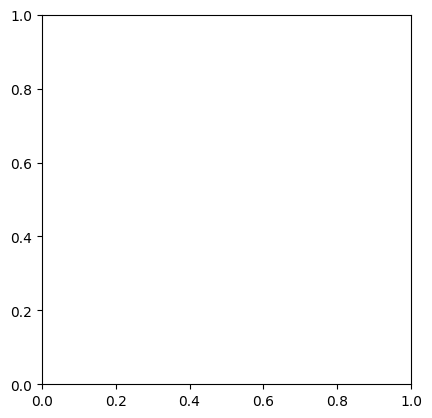

In [242]:
plt.imshow(dF[y_indices[:2*d],:256])

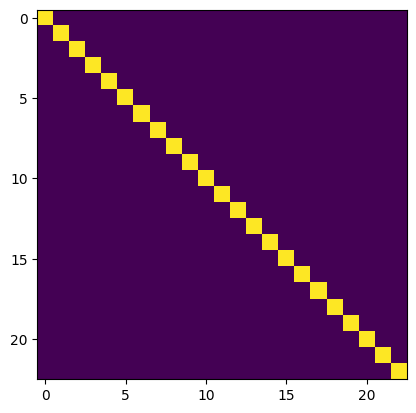

In [11]:
plt.imshow(Y.t() @ Y)

In [86]:
probs

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [122]:
probs.diag()

tensor([[0.4568, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0940, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4509,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.8159, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1452, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0912]])

In [28]:
y_indices

tensor([43, 37, 31, 25, 19, 13,  0,  7,  1, 32, 38, 26, 20, 44, 14, 45, 33,  8,
         2, 39, 27, 15, 34,  9,  3, 40, 21, 46, 10, 41, 28, 22,  4, 16, 47, 48,
        35, 29, 23, 17, 11,  5, 36, 30, 24, 42, 18, 12,  6])

In [30]:
sorted_targets

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        6], dtype=torch.int32)

In [31]:
targets[y_indices]

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        6], dtype=torch.int32)

In [33]:
dF[y_indices,:]

tensor([[ 4.1220e-05, -1.1244e-04, -9.9794e-05,  ...,  2.5571e-04,
         -7.0528e-05, -1.5531e-05],
        [ 8.7528e-06,  3.8684e-04, -3.7546e-05,  ...,  1.9525e-04,
         -6.7284e-05, -4.8323e-04],
        [ 5.6162e-05, -7.9478e-05, -4.7379e-05,  ..., -2.3025e-04,
         -1.1048e-04,  3.3634e-05],
        ...,
        [-1.8350e-04, -2.3147e-04, -8.5033e-04,  ...,  8.1810e-04,
          9.6420e-05,  4.4897e-04],
        [ 2.1295e-04, -1.5683e-04,  5.9404e-04,  ..., -1.9516e-04,
          5.2999e-04,  4.8419e-04],
        [ 2.0057e-04,  4.2506e-05,  1.4783e-04,  ..., -2.9313e-04,
         -3.2939e-04, -4.0468e-04]])

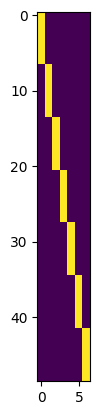

In [35]:
plt.imshow(Y[y_indices,:])

In [17]:
#compute frequency contrastiveness
def freq_contr(v):
    d = v.size(0)
    freq_mag = (U.t() @ v.to(complex_type)).abs()
    freq_mag = freq_mag[1:d//2+1]
    return 2*freq_mag.max() - freq_mag.sum(), freq_mag.max(), freq_mag

In [12]:
### Run some dynamics given the backpropagated gradient.

K = 256
W = nn.Linear(2*d, K, bias=False)

X = X.cuda()
W = W.cuda()
Y = Y.cuda()
probs = probs.cuda()

eps = 1e-1

# optimizer
optimizer = torch.optim.Adam(W.parameters(), lr=0.01, weight_decay=5e-5)

est_upper_W = None

hatYs = []
Ds = []

activation = "sqr"

for t in range(4000):
    optimizer.zero_grad()
    
    # 
    W.train()
    F = W(X)
    
    if activation == "sqr":
        F = F.pow(2)
    elif activation == "relu":
        F[F<0] = 0
    else:
        raise RuntimeError(f"unknown activation {activation}")
        
    # Do normalization
    # F = F - F.mean(dim=0, keepdim=True)
    # F = F / (F.pow(2).mean(dim=0, keepdim=True) + 1e-1).sqrt()
    
    with torch.no_grad():
        dF = compute_dF(F, probs, Y, eps)
    
    if t % 100 == 0:
        w = W.weight.detach()

        indices = (w.norm(dim=1) > 0.2).nonzero().squeeze()
        print(indices.size())

        sum_freq_contr = 0
        sum_freq_max = 0
        
        n_row = int(math.sqrt(indices.size(0)))
        n_col = (indices.size(0) + n_row - 1) // n_row

        for idx, i in enumerate(indices):
            v = w[i, :d].cpu()
            contr, max_value, freq_mag = freq_contr(v)
            sum_freq_contr += contr
            sum_freq_max += max_value
            plt.subplot(n_row, n_col, idx + 1)
            plt.plot(freq_mag)
            plt.axis('off')
        plt.show()

        normalized_freq_contr = sum_freq_contr / sum_freq_max
        print(f"{normalized_freq_contr=}")
        
        # Print out dF
        # plt.imshow(dF[y_indices, :].detach().cpu().numpy())
        # plt.show()
        
        # Check if dF[:, i] has the nice blocky structure
        with torch.no_grad():
            dF_sel = dF[y_indices, :][:, indices]
            all_stds = []
            all_means = []
            for i in range(d):
                sec = dF_sel[i*d:(i+1)*d, :]
                all_stds.append(sec.std(dim=0))
                all_means.append(sec.mean(dim=0))
                
            all_stds = torch.stack(all_stds, dim=1)
            all_means = torch.stack(all_means, dim=1)
            
        print("Mean of stds", all_stds.mean().cpu().numpy())
        print("std of the mean", all_means.std().cpu().numpy())
        print("Ratio", all_stds.mean().cpu().numpy() / all_means.std().cpu().numpy())
        print("mean of the abs(mean)", all_means.abs().mean().cpu().numpy())
        
        plt.imshow(dF[y_indices,:].cpu().numpy())
        for i in range(d):
            plt.axhline(i*d, color='w')
        plt.show()
    
    loss = -(dF * F).sum() / F.size(0) * 2
    loss.backward()
    
    optimizer.step()
    
# plt.legend()
# plt.show()


torch.Size([256])


NameError: name 'freq_contr' is not defined

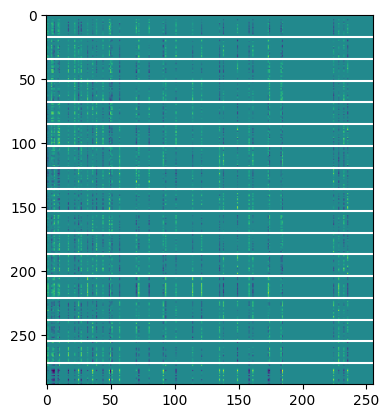

In [173]:
plt.imshow(dF[y_indices,:].cpu().numpy())
for i in range(d):
    plt.axhline(i*d, color='w')

In [134]:
# check the eigenvectors of the data matrix
A = 0

c = torch.randn(d)

for k in range(d):
    sel = (targets == k)
    rho = (torch.rand(d) + 10) * c[k]
    X_sel = X[sel, :]
    A = A + X_sel.t() @ rho.diag() @ X_sel
    
D, V = torch.linalg.eigh(A)
D = D.flip(-1)
V = V.flip(-1)

In [16]:
def plot_freq(v):
    plt.plot((U.t() @ v.to(complex_type)).abs())

In [146]:
probs

tensor([0.4568, 0.0940, 0.4509, 0.5805, 0.1787, 0.8957, 0.2693, 0.3810, 0.6020,
        0.8618, 0.9459, 0.6701, 0.1173, 0.5681, 0.1394, 0.2246, 0.2425, 0.9929,
        0.1137, 0.7165, 0.7482, 0.0509, 0.9641, 0.2815, 0.4266, 0.5847, 0.7480,
        0.6425, 0.2957, 0.0336, 0.1091, 0.0023, 0.7983, 0.7528, 0.2945, 0.4766,
        0.3174, 0.7041, 0.9622, 0.3737, 0.1297, 0.4290, 0.0860, 0.0290, 0.6484,
        0.4552, 0.8415, 0.2754, 0.3353, 0.8665, 0.4262, 0.2705, 0.8879, 0.2230,
        0.6431, 0.6213, 0.4323, 0.1748, 0.5850, 0.6412, 0.2988, 0.3321, 0.8502,
        0.6860, 0.7141, 0.0266, 0.2275, 0.7875, 0.4348, 0.7273, 0.1485, 0.4268,
        0.1906, 0.8227, 0.1775, 0.5802, 0.5837, 0.3649, 0.6396, 0.3946, 0.5554,
        0.5001, 0.1998, 0.0022, 0.0037, 0.6303, 0.1359, 0.9803, 0.8266, 0.1347,
        0.3686, 0.5516, 0.1868, 0.2085, 0.1326, 0.7822, 0.8153, 0.2313, 0.0407,
        0.8016, 0.0849, 0.3144, 0.5162, 0.3618, 0.3568, 0.8059, 0.9659, 0.7674,
        0.8801, 0.7156, 0.6976, 0.2085, 

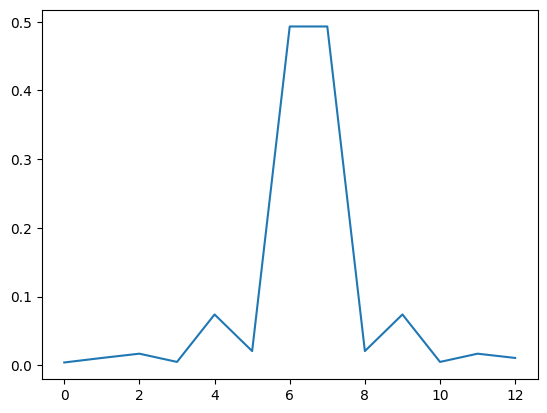

In [135]:
plot_freq(V[:d,0])

In [115]:
V[:,0].shape

torch.Size([14])

In [44]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

logger = logging.getLogger("test")

# Setup iterative procedure between solving dF and eigendecomposition of each node. 
K = 512
W = torch.randn(2*d, K).cuda()

X = X.cuda()
Y = Y.cuda()
probs = probs.cuda()

eps = 1e-2
alpha = 0.2
eta = 0.01

# beta = 0.999

# Duplicate the data matrix K times
dup_Xt = X.t().repeat(K, 1, 1).cuda()
dup_X = X.repeat(K, 1, 1).cuda()

for t in range(100000):
    if t % 10000 == 0:
        logger.info(f"iter {t}")
        
        
    F = X @ W
    F = F ** 2
    
    # compute dF
    dF = compute_dF(F, probs, Y, eps)
    
    # dF_accu = ((1 - beta) * dF + beta * dF_accu) / (1 - beta**(t+1))
    # dF_accu = dF_accu + dF

    scaled_X = dup_X * dF.t()[:,:,None] 

    As = torch.bmm(dup_Xt, scaled_X)
    # Run one step power iteration
    delta_W = torch.bmm(As, W.t()[:,:,None])
    delta_W = delta_W.squeeze(2).t()
    W = W + alpha * delta_W
    W = W / W.norm(dim=0, keepdim=True)
    
    # check the eigenvectors of the data matrix
    # for j in range(K):
    #    A = X.t() @ dF[:,j].diag() @ X
        # W[:, j] += alpha * (A @ W[:,j]) - eta * W[:,j]
        
        # Run one step power iteration
    #    W[:,j] += alpha * A @ W[:,j]
        
        # D, V = torch.linalg.eigh(A)
        # Get the largest eigenvectors and assign it to rows of W
        # if D[-1] < 0:
        #    W[:,j] = 0
        #else:
        #    W[:, j] = V[:, -1]
        
    # Normalize everything
    # W = W / W.norm(dim=0, keepdim=True)
        
    # decaying eps
    # if t % 10 == 0:
    #     eps = eps / 2


2025-08-02 16:07:02 - iter 0
2025-08-02 16:07:32 - iter 10000
2025-08-02 16:08:02 - iter 20000
2025-08-02 16:08:32 - iter 30000
2025-08-02 16:09:01 - iter 40000
2025-08-02 16:09:32 - iter 50000
2025-08-02 16:10:01 - iter 60000
2025-08-02 16:10:31 - iter 70000
2025-08-02 16:11:01 - iter 80000
2025-08-02 16:11:31 - iter 90000


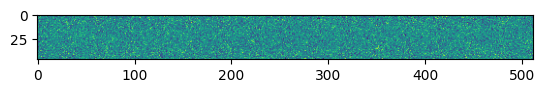

In [28]:
plt.imshow(W.cpu())

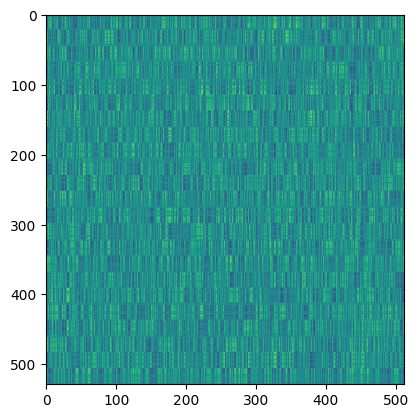

In [24]:
plt.imshow(dF[y_indices,:].cpu())

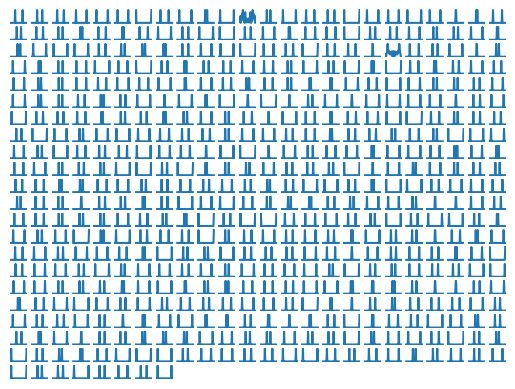

normalized_freq_contr=tensor(0.9835, dtype=torch.float64)


In [45]:
indices = (W.norm(dim=0) > 0.2).nonzero().squeeze().cpu()

active_K = indices.size(0)

n_row = int(math.sqrt(active_K))
n_col = (active_K + n_row - 1) // n_row

sum_freq_contr = 0
sum_freq_max = 0

for idx, j in enumerate(indices.tolist()):
    v = W[:d,j].cpu()
    contr, max_value, freq_mag = freq_contr(v)
    sum_freq_contr += contr
    sum_freq_max += max_value

    plt.subplot(n_row, n_col, idx + 1)
    plot_freq(v)
    plt.axis('off')

plt.show()

normalized_freq_contr = sum_freq_contr / sum_freq_max
print(f"{normalized_freq_contr=}")


In [70]:
indices.size()

torch.Size([81])

In [131]:
probs

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 